In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
print(os.getcwd())
print(os.chdir('/home/jovyan/project/AnomLLM/'))
print(os.getcwd())

import sys
sys.path.append('./src')

/home/jovyan/project/AnomLLM/notebook/finding1-localization
None
/home/jovyan/project/AnomLLM


In [3]:
from prompt import time_series_to_image, LIMIT_PROMPT, PROMPT, time_series_to_str
from utils import view_base64_image, display_messages, collect_results
from utils import interval_to_vector, vector_to_interval
from data.synthetic import SyntheticDataset
import pandas as pd
import numpy as np
import re
from sklearn.metrics import precision_score, recall_score
from affiliation.generics import convert_vector_to_events
from affiliation.metrics import pr_from_events
from utils import compute_metrics

import glob

In [4]:
def average_dict_values(dict_list):
    sums = {}
    counts = {}

    for d in dict_list:
        for key, value in d.items():
            sums[key] = sums.get(key, 0) + value
            counts[key] = counts.get(key, 0) + 1
            
    # 각 키에 대해 평균 계산: 합계 / 등장횟수
    averages = {key: sums[key] / counts[key] for key in sums}
    return averages

In [5]:
text = """
여기에 전체 텍스트를 넣으세요.
예시:
anomaly data 1:
-0.13 -1.22 0.3 -0.13 -0.08 -0.74 0.74 -0.01 0.18 0.21 0.42 -0.15 -0.01 0.05 0.33 -0.07
다른 내용이 있을 수도 있습니다.
anomaly data 2:
0.10 0.20 0.30 0.40 0.50
"""
def extract_anomaly_sequences(text):
    pattern = r"anomaly data\s*\d+:\s*([-\d.\s]+)"
    matches = re.findall(pattern, text)
    
    anomaly_sequences = []
    for match in matches:
        # 매치된 문자열을 공백 기준으로 분리하고 float형으로 변환
        numbers = [float(num) for num in match.strip().split()]
        anomaly_sequences.append(numbers)
    
    return anomaly_sequences

extract_anomaly_sequences(text)

[[-0.13,
  -1.22,
  0.3,
  -0.13,
  -0.08,
  -0.74,
  0.74,
  -0.01,
  0.18,
  0.21,
  0.42,
  -0.15,
  -0.01,
  0.05,
  0.33,
  -0.07],
 [0.1, 0.2, 0.3, 0.4, 0.5]]

In [6]:
data_name = 'range'
data_dir = f'data/synthetic/{data_name}/eval/'
train_dir = f'data/synthetic/{data_name}/train/'
eval_dataset = SyntheticDataset(data_dir)
eval_dataset.load()
train_dataset = SyntheticDataset(train_dir)
train_dataset.load()

Loaded dataset range with 400 series.
Loaded dataset range with 400 series.


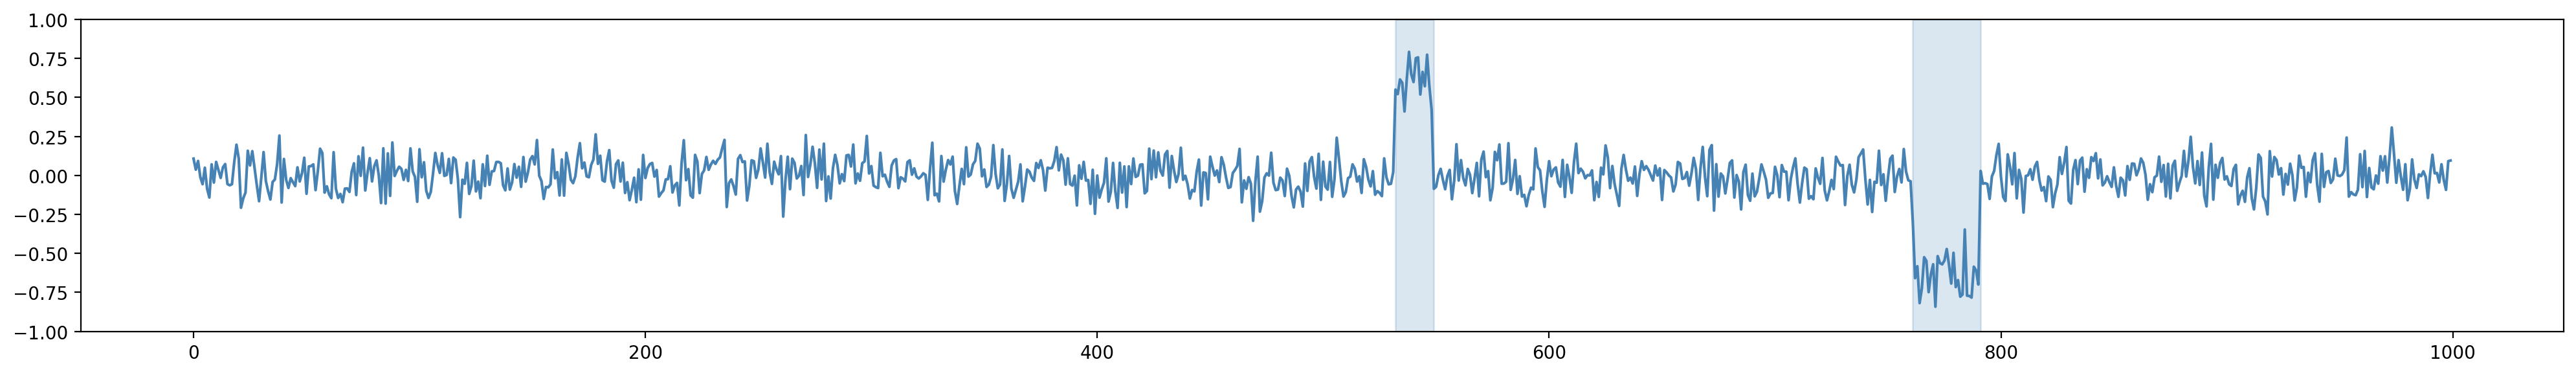

In [7]:
from utils import plot_series_and_predictions

idx = 169
directory = f'results/synthetic/{data_name}'
series = eval_dataset[idx][1].numpy()
anomaly_locations = eval_dataset[idx][0].numpy()

raw_results = collect_results(directory, raw=True)
raw_results = {k: v[idx] for k, v in raw_results.items()}

results = collect_results(directory)
results = {k: v[idx] for k, v in results.items()  if len(v) > idx}

fig = plot_series_and_predictions(
    series=series, 
    gt_anomaly_intervals=anomaly_locations,
    anomalies=None, #results
)

In [8]:
for k, v in results.items():
    print(k, len(v))

gpt-4o (0shot-vision) 1000
gpt-4o (localization(rawData)_junwoo_index-True) 1000
gpt-4o (localization(rawData)_junwoo) 1000
gpt-4o (0shot-text) 1000
gemini-1.5-flash (0shot-vision) 1000
gemini-1.5-flash (localization(rawData)_junwoo_index-True) 1000
gemini-1.5-flash (localization(rawData)_junwoo) 1000
gemini-1.5-flash (range-gemini-1.5-flash-0shot-text) 1000
gpt-4o-mini (0shot-vision) 1000
gpt-4o-mini (localization(rawData)_junwoo_index-True) 1000
gpt-4o-mini (localization(rawData)_junwoo) 1000
gpt-4o-mini (0shot-text) 1000


### Evaluation

In [9]:
model_name = 'gemini-1.5-flash' #'gpt-4o-mini' #'gemini-1.5-flash'
aaa = glob.glob(f'./results/synthetic/{data_name}/{model_name}/*')
aaa

['./results/synthetic/range/gemini-1.5-flash/0shot-vision.jsonl',
 './results/synthetic/range/gemini-1.5-flash/localization(rawData)_junwoo_index-True.jsonl',
 './results/synthetic/range/gemini-1.5-flash/localization(rawData)_junwoo.jsonl',
 './results/synthetic/range/gemini-1.5-flash/range-gemini-1.5-flash-0shot-text.jsonl']

In [10]:
raise Exception()

Exception: 

In [11]:
json_name = './results/synthetic/range/gemini-1.5-flash/localization(rawData)_junwoo_index-True.jsonl'
result_df = pd.read_json(json_name, lines=True)
result_df['input_prompt'] = result_df['request'].apply(lambda x:x['messages'][0]['content'])
result_df['eval_idx'] = result_df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
result_df['incontext'] = result_df['input_prompt'].apply(lambda x:extract_anomaly_sequences(x))
result_df.head(10)

,custom_id,request,response,input_prompt,eval_idx,incontext
0,range_gemini-1.5-flash_localization(rawData)_j...,"{'messages': [{'role': 'user', 'content': '(0,...",[],"(0,0.05), (1,-0.02), (2,-0.06), (3,-0.01), (4,...",1,[]
1,range_gemini-1.5-flash_localization(rawData)_j...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[{""start"": 969, ""end"": 973}]\n```\n","(0,0.03), (1,0.08), (2,0.15), (3,0.05), (4,0.0...",2,"[[0.14, 0.78, 0.61, 0.49, 0.66, 0.4]]"
2,range_gemini-1.5-flash_localization(rawData)_j...,"{'messages': [{'role': 'user', 'content': '(0,...",[],"(0,-0.04), (1,0.11), (2,-0.16), (3,-0.12), (4,...",3,[]
3,range_gemini-1.5-flash_localization(rawData)_j...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[\n {\n ""start"": 403,\n ""end"":...","(0,0.05), (1,0.09), (2,0.13), (3,0.16), (4,-0....",4,"[[-0.0, -0.42, -0.58, -0.65, -0.71, -0.67, -0...."
4,range_gemini-1.5-flash_localization(rawData)_j...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[{""start"": 492, ""end"": 496}]\n```\n","(0,-0.01), (1,0.01), (2,0.07), (3,-0.19), (4,-...",5,"[[0.05, 0.52, 0.37, 0.53, 0.58, 0.62]]"
5,range_gemini-1.5-flash_localization(rawData)_j...,"{'messages': [{'role': 'user', 'content': '(0,...","```json\n[{""start"": 934, ""end"": 938}]\n```\n","(0,0.03), (1,-0.01), (2,-0.11), (3,0.02), (4,-...",6,"[[-0.12, -0.69, -0.64, -0.58, -0.79, -0.41]]"
6,range_gemini-1.5-flash_localization(rawData)_j...,"{'messages': [{'role': 'user', 'content': '(0,...",[],"(0,-0.1), (1,0.0), (2,-0.13), (3,-0.01), (4,-0...",7,[]
7,range_gemini-1.5-flash_localization(rawData)_j...,"{'messages': [{'role': 'user', 'content': '(0,...",[],"(0,-0.02), (1,0.1), (2,-0.05), (3,0.09), (4,-0...",8,[]
8,range_gemini-1.5-flash_localization(rawData)_j...,"{'messages': [{'role': 'user', 'content': '(0,...",[],"(0,0.08), (1,0.11), (2,0.11), (3,-0.09), (4,-0...",9,[]
9,range_gemini-1.5-flash_localization(rawData)_j...,"{'messages': [{'role': 'user', 'content': '(0,...",[],"(0,0.03), (1,0.08), (2,-0.01), (3,0.15), (4,0....",10,[]


In [12]:
raw_result = collect_results(f'./results/synthetic/{data_name}/{model_name}/')
raw_result.keys()

dict_keys([' (0shot-vision)', ' (localization(rawData)_junwoo_index-True)', ' (localization(rawData)_junwoo)', ' (range-gemini-1.5-flash-0shot-text)'])

In [13]:
key_name = json_name.split('/')[-1].replace('.jsonl', '')
target_res = raw_result[f' ({key_name})']
len(target_res)

400

In [14]:
vis_idx = 0
result_df['response'].iloc[vis_idx]

'[]'

In [15]:
print(result_df['input_prompt'].iloc[vis_idx])

(0,0.05), (1,-0.02), (2,-0.06), (3,-0.01), (4,0.14), (5,0.12), (6,-0.04), (7,0.05), (8,-0.04), (9,0.1), (10,0.03), (11,0.02), (12,0.1), (13,-0.0), (14,0.1), (15,-0.06), (16,-0.01), (17,0.09), (18,-0.1), (19,0.02), (20,0.07), (21,0.09), (22,0.05), (23,0.08), (24,0.08), (25,-0.12), (26,0.11), (27,-0.2), (28,0.04), (29,-0.06), (30,0.04), (31,-0.01), (32,0.05), (33,0.06), (34,0.04), (35,0.1), (36,0.18), (37,-0.05), (38,0.04), (39,-0.06), (40,-0.02), (41,-0.11), (42,-0.02), (43,-0.05), (44,0.06), (45,-0.05), (46,-0.02), (47,0.24), (48,0.03), (49,0.33), (50,-0.05), (51,-0.08), (52,0.01), (53,0.07), (54,-0.28), (55,-0.1), (56,0.22), (57,0.06), (58,0.17), (59,0.02), (60,0.1), (61,0.03), (62,0.03), (63,0.21), (64,0.03), (65,0.04), (66,0.05), (67,0.12), (68,-0.05), (69,0.04), (70,0.11), (71,0.15), (72,0.11), (73,-0.02), (74,-0.11), (75,-0.15), (76,-0.15), (77,-0.05), (78,0.07), (79,-0.03), (80,0.02), (81,0.08), (82,0.1), (83,0.01), (84,0.02), (85,0.1), (86,0.1), (87,-0.05), (88,0.21), (89,0.19),

In [16]:
vector_to_interval(target_res[vis_idx])

[]

In [17]:
eval_sample_idx = result_df.iloc[vis_idx].eval_idx -1

series = eval_dataset[eval_sample_idx][1].numpy()
anomaly_locations = eval_dataset[eval_sample_idx][0].numpy()
anomaly_locations.shape

(1, 0)

In [18]:
gt = interval_to_vector(anomaly_locations[0], end=1000)
pred_vector = target_res[vis_idx]
our_metric = compute_metrics(gt, pred_vector)
our_metric

{'precision': 1,
 'recall': 1,
 'f1': 1,
 'affi precision': 1,
 'affi recall': 1,
 'affi f1': 1}

In [19]:
anomaly_indexs = []
normal_indexs = []

eval_results = []
for i, eval_data in enumerate(eval_dataset):
    sample_ano_loc, sample_series = eval_data
    
    if sample_ano_loc.shape[-1] == 0:
        normal_indexs.append(i)
        dummy_res = {'precision': 0,
         'recall': 0,
         'f1': 0,
         'affi precision': 0,
         'affi recall': 0,
         'affi f1': 0}
        eval_results.append(dummy_res)
        continue
    
    anomaly_indexs.append(i) 
        
    res_idx = result_df[result_df.eval_idx == i+1].index[0] # index가 0부터 399까지
    pred_vector = target_res[res_idx]
    gt = interval_to_vector(sample_ano_loc[0], end=1000)
    our_metric = compute_metrics(gt, pred_vector)
    eval_results.append(our_metric)

    if i % 20 == 0:
        print(i, sample_ano_loc.shape)

20 torch.Size([1, 1, 2])
80 torch.Size([1, 2, 2])
100 torch.Size([1, 1, 2])
120 torch.Size([1, 1, 2])
160 torch.Size([1, 1, 2])
180 torch.Size([1, 1, 2])
220 torch.Size([1, 3, 2])
280 torch.Size([1, 1, 2])
300 torch.Size([1, 2, 2])
320 torch.Size([1, 2, 2])
340 torch.Size([1, 1, 2])
360 torch.Size([1, 1, 2])
380 torch.Size([1, 4, 2])


In [20]:
len(anomaly_indexs), len(normal_indexs), 

(279, 121)

In [ ]:
ano_results = [eval_results[a_idx] for a_idx in anomaly_indexs]

In [ ]:
total_res = average_dict_values(eval_results)
for k, v in total_res.items():
    print(f"{k}: {v*100:.2f}")

In [ ]:
total_res = average_dict_values(ano_results)
print('only Anomalies')
for k, v in total_res.items():
    print(f"{k}: {v*100:.2f}")

### Sample 단위 검증
* 입력이 잘 들어갔는지
* 메트릭 계산시에 pair가 잘 맞는지

In [ ]:
result_df

In [ ]:
sample_idx = 5
sample_res = result_df.iloc[sample_idx]
sample_res

In [ ]:
ano_locs, series = eval_dataset[sample_res.eval_idx - 1]
print(ano_locs.shape, series.shape)
raw_series = series[:,0]

fig = plot_series_and_predictions(
    series=series, 
    gt_anomaly_intervals=ano_locs,
    gt_ylim = (series.min(), series.max()),
    anomalies=None, #results
)
print(ano_locs[0])

In [ ]:
# infer_series = np.array(sample_res.input_prompt.split('\n')[0].split(' ')).astype(float).reshape(-1, 1)
infer_series = np.array([a.replace(')', '').split(',')[-1] for a in sample_res.input_prompt.split('\n')[0].split(', ')]).astype(float).reshape(-1, 1)
infer_loc = vector_to_interval(target_res[sample_idx])
infer_loc = np.array(infer_loc)[np.newaxis, ... ]
print(infer_loc)
fig = plot_series_and_predictions(
    series=infer_series, 
    gt_anomaly_intervals=infer_loc,
    gt_ylim = (infer_series.min(), infer_series.max()),
    anomalies=None, #results
)

ax = fig.axes[0]
for ano_loc, ano_series in zip(ano_locs[0], sample_res.incontext):
    st_ano, end_ano = ano_loc.numpy().astype(int)
    print(st_ano, end_ano, len(ano_series))
    ax.plot(np.arange(st_ano-1, end_ano), ano_series, color='red')

In [ ]:
eval_results[sample_idx]